<a href="https://colab.research.google.com/github/dcolinmorgan/MIMB/blob/main/PRS_MMoll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,gc,glob
# import s3fs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from psutil import *
import scipy.io
from scipy.stats import zscore
import datetime
from sklearn import metrics
import traceback
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
conv=pd.read_csv('drive/MyDrive/PRS_MMoll/conv.txt',sep=' ',names=['gene','sid'])
# data=pd.read_csv('drive/MyDrive/PRS_MMoll/fulldata2.txt',sep='\t',index_col=0)
pheno=pd.read_csv('drive/MyDrive/PRS_MMoll/phenoall.txt',sep=' ')


In [25]:
data2=data.merge(conv,on=['sid'])
data2.index=data2.gene
del data2['sid'] 
del data2['gene']

In [ ]:
data2

In [229]:
# pheno2=pheno[['sid','trs','prs_composite']]
PRS1=data2[pheno.sid[pheno2['prs_composite']>2]]
PRS0=data2[pheno.sid[pheno2['prs_composite']<-2]]

TRS1=data2[pheno.sid[pheno2['trs']>2]]
TRS0=data2[pheno.sid[pheno2['trs']<-2]]

In [230]:
PRS1.to_csv('drive/MyDrive/PRS_MMoll/PRS1.txt',sep='\t',header=False,index=True)
PRS0.to_csv('drive/MyDrive/PRS_MMoll/PRS0.txt',sep='\t',header=False,index=True)
TRS1.to_csv('drive/MyDrive/PRS_MMoll/TRS1.txt',sep='\t',header=False,index=True)
TRS0.to_csv('drive/MyDrive/PRS_MMoll/TRS0.txt',sep='\t',header=False,index=True)

In [231]:
[PRS1.shape[1],PRS0.shape[1],TRS1.shape[1],TRS0.shape[1]]

[57, 54, 90, 27]

In [232]:
# !git clone --single-branch --branch milipede_beta https://github.com/dcolinmorgan/netZooPy.git
# os.chdir('netZooPy')
# !pip install -e ./

In [233]:
# import netZooPy
# from netZooPy.panda import Panda
# from netZooPy.lioness import Lioness
# from netZooPy.milipede import Milipede ## just commented out to use reload above
# os.chdir('..')

In [234]:

# ppi=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/ppi/ppi_complete.txt',sep='\t',header=0)

# med_mot=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/motifs/Hugo_motifCellLine.txt',sep='\t',header=0)

In [235]:
# !wget https://granddb.s3.amazonaws.com/optPANDA/ppi/ppi_complete.txt
# !wget https://granddb.s3.amazonaws.com/optPANDA/motifs/Hugo_motifCellLine.txt

In [ ]:
panda_objP1=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/PRS1.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',


# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')
# panda_objP1.save_panda_results('drive/MyDrive/PRS_MMoll/PRS1.txt')
panda_objP1.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/PRS1.txt')

In [ ]:
panda_objP0=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/PRS0.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',
    # save_fmt='npy',map_file='netZooPy/tests/milipeed/MotifPrior_CGmap.txt')

# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')
# panda_objP0.save_panda_results('drive/MyDrive/PRS_MMoll/PRS0.txt')
panda_objP0.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/PRS0.txt')

In [238]:
FC=pd.read_csv('drive/MyDrive/PRS_MMoll/PRS1.txt',sep=',',index_col=0)
FNC=pd.read_csv('drive/MyDrive/PRS_MMoll/PRS0.txt',sep=',',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [239]:
TFsum_4=FC.groupby(['tf']).agg({'force':sum})
TFsum_2=FNC.groupby(['tf']).agg({'force':sum})
TFsum_2['force']=zscore(TFsum_2['force'])
TFsum_4['force']=zscore(TFsum_4['force']) ##reduces range from 2500 to 4

geneSum_4=FC.groupby(['gene']).agg({'force':sum})
geneSum_2=FNC.groupby(['gene']).agg({'force':sum})
geneSum_4['force']=zscore(geneSum_4['force'])
geneSum_2['force']=zscore(geneSum_2['force'])

mmm=TFsum_4.merge(TFsum_2, left_on=['tf'], right_on=['tf'])
mmmm=geneSum_4.merge(geneSum_2, left_on=['gene'], right_on=['gene'])

# del [[FC, FNC]]
# gc.collect()
FC=pd.DataFrame()
FNC=pd.DataFrame()
Panda_FcontFULL=pd.DataFrame()
Panda_FcontFULL=pd.DataFrame()


mmm['diff']=mmm.force_x-mmm.force_y
mmm = mmm.sort_values(by ='diff' )


mmmm['diff']=mmmm.force_x-mmmm.force_y
mmmm = mmmm.sort_values(by ='diff' )
mmm.to_csv('drive/My Drive/PRS_MMoll/TF_zscore_PRS.txt',sep='\t')
mmmm.to_csv('drive/My Drive/PRS_MMoll/gene_zscore_PRS.txt',sep='\t')

In [ ]:
panda_objT1=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/TRS1.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',
    # save_fmt='npy',map_file='netZooPy/tests/milipeed/MotifPrior_CGmap.txt')

# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')

panda_objT1.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/TRS1.txt')

In [ ]:
panda_objT0=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/TRS0.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',
    # save_fmt='npy',map_file='netZooPy/tests/milipeed/MotifPrior_CGmap.txt')

# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')

panda_objT0.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/TRS0.txt')

In [242]:
MC=pd.read_csv('drive/MyDrive/PRS_MMoll/TRS1.txt',sep=',',index_col=0)
MNC=pd.read_csv('drive/MyDrive/PRS_MMoll/TRS0.txt',sep=',',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [243]:
TFsum_3=MC.groupby(['tf']).agg({'force':sum})
TFsum_1=MNC.groupby(['tf']).agg({'force':sum})
TFsum_1['force']=zscore(TFsum_1['force'])
TFsum_3['force']=zscore(TFsum_3['force']) ##reduces range from 1500 to 3

geneSum_3=MC.groupby(['gene']).agg({'force':sum})
geneSum_1=MNC.groupby(['gene']).agg({'force':sum})
geneSum_3['force']=zscore(geneSum_3['force'])
geneSum_1['force']=zscore(geneSum_1['force'])

mmm=TFsum_3.merge(TFsum_1, left_on=['tf'], right_on=['tf'])
mmmm=geneSum_3.merge(geneSum_1, left_on=['gene'], right_on=['gene'])

# del [[MC, MNC]]
# gc.collect()
MC=pd.DataFrame()
MNC=pd.DataFrame()
# Panda_FcontFULL=pd.DataFrame()
# Panda_FcontFULL=pd.DataFrame()


mmm['diff']=mmm.force_x-mmm.force_y
mmm = mmm.sort_values(by ='diff' )


mmmm['diff']=mmmm.force_x-mmmm.force_y
mmmm = mmmm.sort_values(by ='diff' )
mmm.to_csv('drive/My Drive/PRS_MMoll/TF_zscore_TPR.txt',sep='\t')
mmmm.to_csv('drive/My Drive/PRS_MMoll/gene_zscore_TPR.txt',sep='\t')

In [244]:
ff=pd.read_csv('drive/My Drive/PRS_MMoll/TF_zscore_PRS.txt',sep='\t',header=0)
fff=pd.read_csv('drive/My Drive/PRS_MMoll/gene_zscore_PRS.txt',sep='\t',header=0)
mm=pd.read_csv('drive/My Drive/PRS_MMoll/TF_zscore_TPR.txt',sep='\t',header=0)
mmm=pd.read_csv('drive/My Drive/PRS_MMoll/gene_zscore_TPR.txt',sep='\t',header=0)

sex_tf_diffB=ff.merge(mm,on='tf')
sex_tf_diffB.columns=['TF','F_case','F_cont','Fdiff','M_case','M_cont','Mdiff']
sex_tf_diffB.to_csv('drive/My Drive/PRS_MMoll/TF_PRS-TPS_diff.txt',sep='\t',index=0)


sex_gene_diffB=fff.merge(mmm,on='gene')
sex_gene_diffB.columns=['gene','F_case','F_cont','Fdiff','M_case','M_cont','Mdiff']
sex_gene_diffB.to_csv('drive/My Drive/PRS_MMoll/gene_PRS-TPS_diff.txt',sep='\t',index=0)


In [245]:
# sex_tf_diffA=sex_tf_diffA.sort_values('tf')
sex_tf_diffB=sex_tf_diffB.sort_values('TF')
# sex_gene_diffA=sex_gene_diffA.sort_values('gene')
sex_gene_diffB=sex_gene_diffB.sort_values('gene')

In [246]:
sex_tf_diffB

,TF,F_case,F_cont,Fdiff,M_case,M_cont,Mdiff
512,AHR,0.192387,0.153793,0.038594,0.261180,0.280738,-0.019558
533,AIRE,0.484395,0.442249,0.042146,0.545936,0.563405,-0.017468
610,ALX1,0.270317,0.209309,0.061008,0.332964,0.349821,-0.016858
563,ALX3,0.169611,0.120858,0.048754,0.239453,0.264331,-0.024878
550,ALX4,0.125669,0.080054,0.045616,0.188520,0.209740,-0.021220
...,...,...,...,...,...,...,...
625,ZNF75A,0.443660,0.369056,0.074604,0.330208,0.293696,0.036512
247,ZNF784,-0.555954,-0.547430,-0.008523,-0.568471,-0.562222,-0.006249
94,ZSCAN10,-0.387073,-0.338149,-0.048924,-0.393283,-0.395436,0.002153
244,ZSCAN16,-0.035496,-0.025572,-0.009924,-0.012203,-0.056916,0.044712


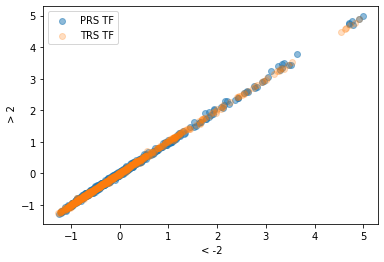

In [249]:
p1=plt.scatter(sex_tf_diffB['F_case'],sex_tf_diffB['F_cont'],alpha=.5)
p2=plt.scatter(sex_tf_diffB['M_case'],sex_tf_diffB['M_cont'],alpha=.25)
plt.ylabel(' > 2')
plt.xlabel(' < -2')
plt.legend((p1, p2),('PRS TF','TRS TF'))

In [256]:
sex_tf_diffB['ab_diff']=sex_tf_diffB['Fdiff']-sex_tf_diffB['Mdiff']
sex_tf_diffB.sort_values(by='ab_diff')

,TF,F_case,F_cont,Fdiff,M_case,M_cont,Mdiff,ab_diff
0,PURA,1.744944,1.896916,-0.151971,1.683525,1.695937,-0.012411,-0.139560
1,ZNF281,3.112136,3.256927,-0.144791,3.021278,3.027224,-0.005946,-0.138845
4,MAZ,3.636303,3.776831,-0.140528,3.537865,3.541068,-0.003203,-0.137324
3,ZNF148,3.247254,3.388467,-0.141214,3.159084,3.163018,-0.003935,-0.137279
2,ZNF263,3.362950,3.507477,-0.144527,3.290386,3.301328,-0.010942,-0.133585
...,...,...,...,...,...,...,...,...
630,TBPL2,1.575563,1.492985,0.082579,1.635900,1.652633,-0.016733,0.099312
631,SIX5,0.065324,-0.026688,0.092013,-0.031892,-0.023911,-0.007981,0.099994
579,OSR1,-0.742643,-0.795102,0.052459,-0.871249,-0.790436,-0.080813,0.133272
627,ZBTB33,-0.799604,-0.876128,0.076524,-0.867748,-0.776770,-0.090978,0.167502


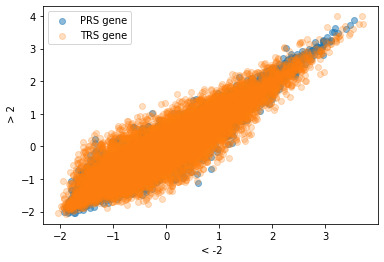

In [250]:
p1=plt.scatter(sex_gene_diffB['F_case'],sex_gene_diffB['F_cont'],alpha=.5)
p2=plt.scatter(sex_gene_diffB['M_case'],sex_gene_diffB['M_cont'],alpha=.25)
plt.ylabel(' > 2')
plt.xlabel(' < -2')
plt.legend((p1, p2),('PRS gene','TRS gene'))

In [ ]:
sex_gene_diffB['ab_diff']=sex_gene_diffB['Fdiff']-sex_gene_diffB['Mdiff']
sex_gene_diffB.sort_values(by='ab_diff')

(array([  1.,  31., 122.,   0.,   0.,   0.,   0., 148.,  68.,  11.]),
 array([-2.26970411, -1.82239144, -1.37507877, -0.92776609, -0.48045342,
        -0.03314075,  0.41417193,  0.8614846 ,  1.30879727,  1.75610995,
         2.20342262]),
 <a list of 10 Patch objects>)

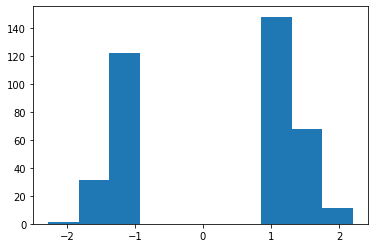

In [262]:
plt.hist(sex_gene_diffB.ab_diff[np.abs(sex_gene_diffB.ab_diff)>1],bins=10)

In [265]:
sex_gene_diffB.gene[np.abs(sex_gene_diffB.ab_diff)>2]

1           DHFR
10066      PRMT2
9858     SLC35B1
10075      VWA5A
Name: gene, dtype: object